In [12]:
import sys
import os
import matplotlib.pyplot as plt
import math
import random
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.patch_utils import extract_patches
from src.feature_extractor import *
from src.search_engine import FaissSearch

print("Imports successful!")

Imports successful!


In [8]:
# Configuration
IMAGE_PATH = '../data/raw_maps/sample_venice_map_3.jpg'
# PATCH_SIZE = (224, 224)
# STRIDE = (112, 112)  # 50% overlap
PATCH_SIZE = (112, 112)
STRIDE = (56, 56)  # 50% overlap
K_NEIGHBORS = 20  # Number of search results
MODEL = 'openai/clip-vit-base-patch32'
MODEL = 'PE-Core-B16-224'
FEATURE_DIM = 512  # Feature dimension for CLIP
FEATURE_DIM = 1024  # Feature dimension for PE

In [9]:
# Tile Extraction
patches_data = extract_patches(IMAGE_PATH, patch_size=PATCH_SIZE, stride=STRIDE)
patch_images = [item['patch'] for item in patches_data]

Extracting patches from ../data/raw_maps/sample_venice_map_3.jpg...


Patching Image: 100%|██████████| 4171/4171 [00:00<00:00, 14423.53it/s]

Successfully extracted 4171 patches.


In [10]:
# Feature Extraction
extractor = PEFeatureExtractor(model_name=MODEL)
image_features = extractor.extract_image_features(patch_images)
print(f"\nFeature extraction complete. Feature matrix shape: {image_features.shape}")

FeatureExtractor (Perception Encoder) using device: cuda
Missing keys for loading model: []
Unexpected keys for loading model: []
模型 PE-Core-B16-224 加载成功。图像大小: 224px
Extracting image features using PE-Core-B16-224...


Extracting PE Features: 100%|██████████| 66/66 [07:55<00:00,  7.20s/it]



Feature extraction complete. Feature matrix shape: (4171, 1024)


In [11]:
# Build FAISS Index
search_engine = FaissSearch(feature_dim=FEATURE_DIM)
search_engine.build_index(image_features)

FAISS: No GPU support detected. Using CPU.
Building index with 4171 vectors...
Index built. Total vectors in index: 4171


--- Demo 1: Image-to-Image Search ---


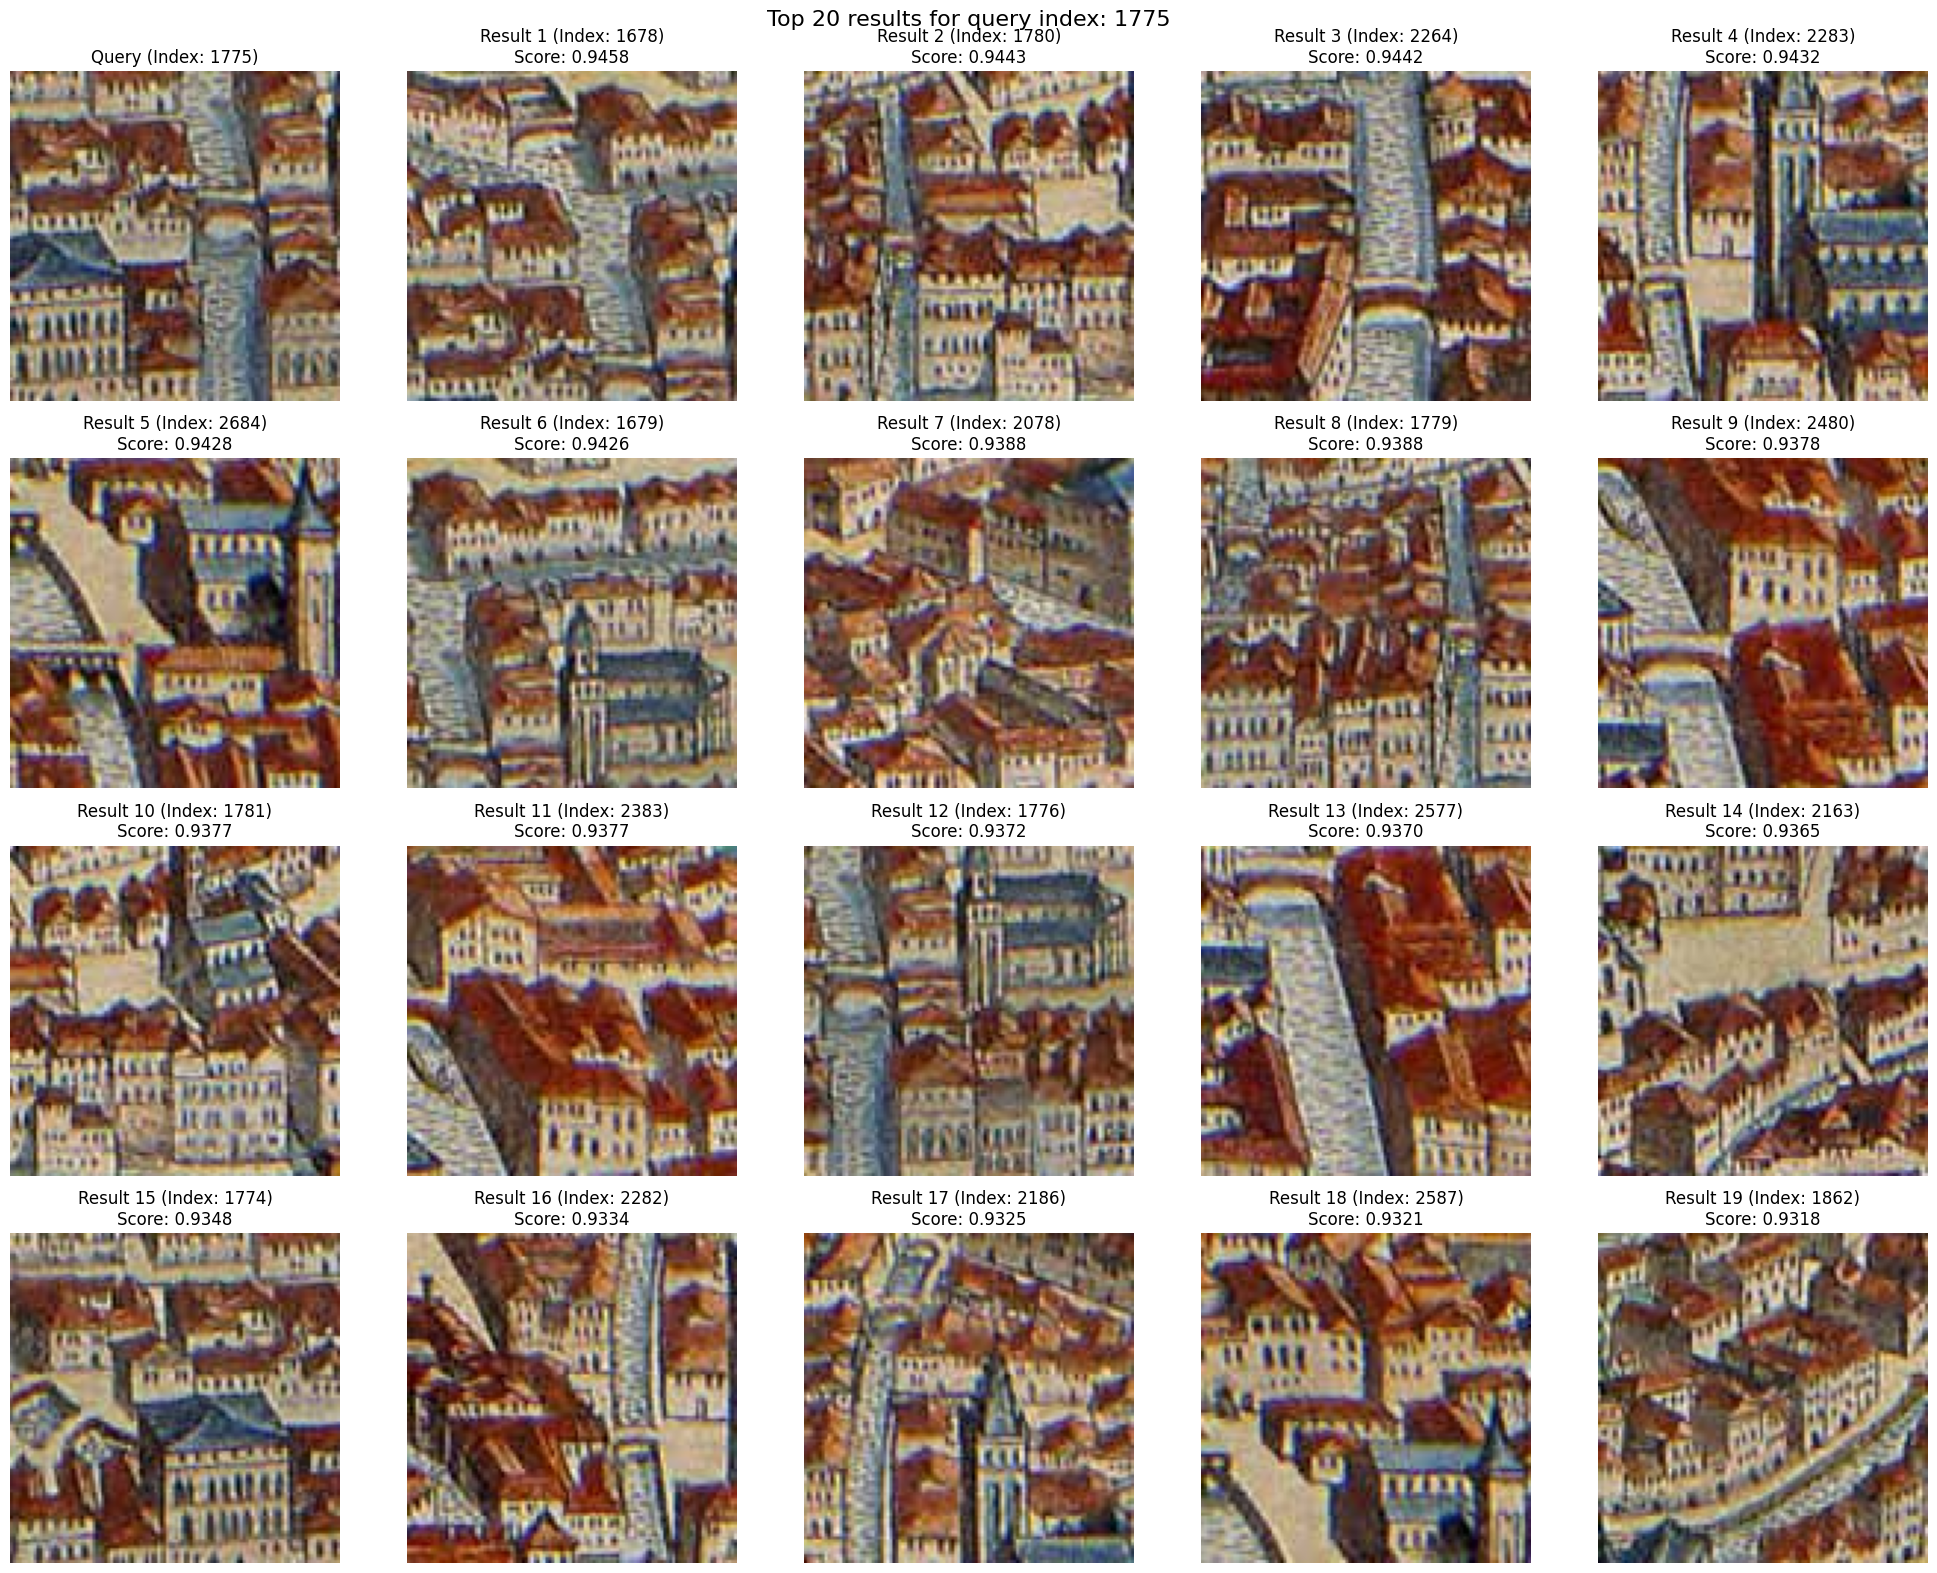

In [15]:
## Search Demo 1 - Image-to-Image
print("--- Demo 1: Image-to-Image Search ---")

# Randomly select a tile as the query
query_index = random.randint(0, len(patches_data) - 1)
query_patch = patches_data[query_index]['patch']
query_vector = np.expand_dims(image_features[query_index], axis=0)  # Keep 2D shape

# Execute the search
distances, indices = search_engine.search(query_vector, k=K_NEIGHBORS)

# Visualization parameters
COLS_PER_ROW = 5
ROWS = math.ceil(K_NEIGHBORS / COLS_PER_ROW)

# Create a grid (e.g., 3 rows × 5 columns)
fig, axes = plt.subplots(ROWS, COLS_PER_ROW, figsize=(20, 4 * ROWS))
fig.suptitle(f"Top {K_NEIGHBORS} results for query index: {query_index}", fontsize=16)

axes_flat = axes.flat

for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    ax = axes_flat[i]
    result_patch = patches_data[idx]['patch']

    # Highlight the query image
    if i == 0:
        ax.imshow(result_patch)
        ax.set_title(f"Query (Index: {idx})")
    else:
        ax.imshow(result_patch)
        ax.set_title(f"Result {i} (Index: {idx})\nScore: {dist:.4f}")
    ax.axis('off')

# Hide extra empty subplots if K is not a multiple of 5
for i in range(len(indices[0]), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()



--- Demo 2: Text-to-Image Search ---
Extracting text features for: 'an arched bridge over water'


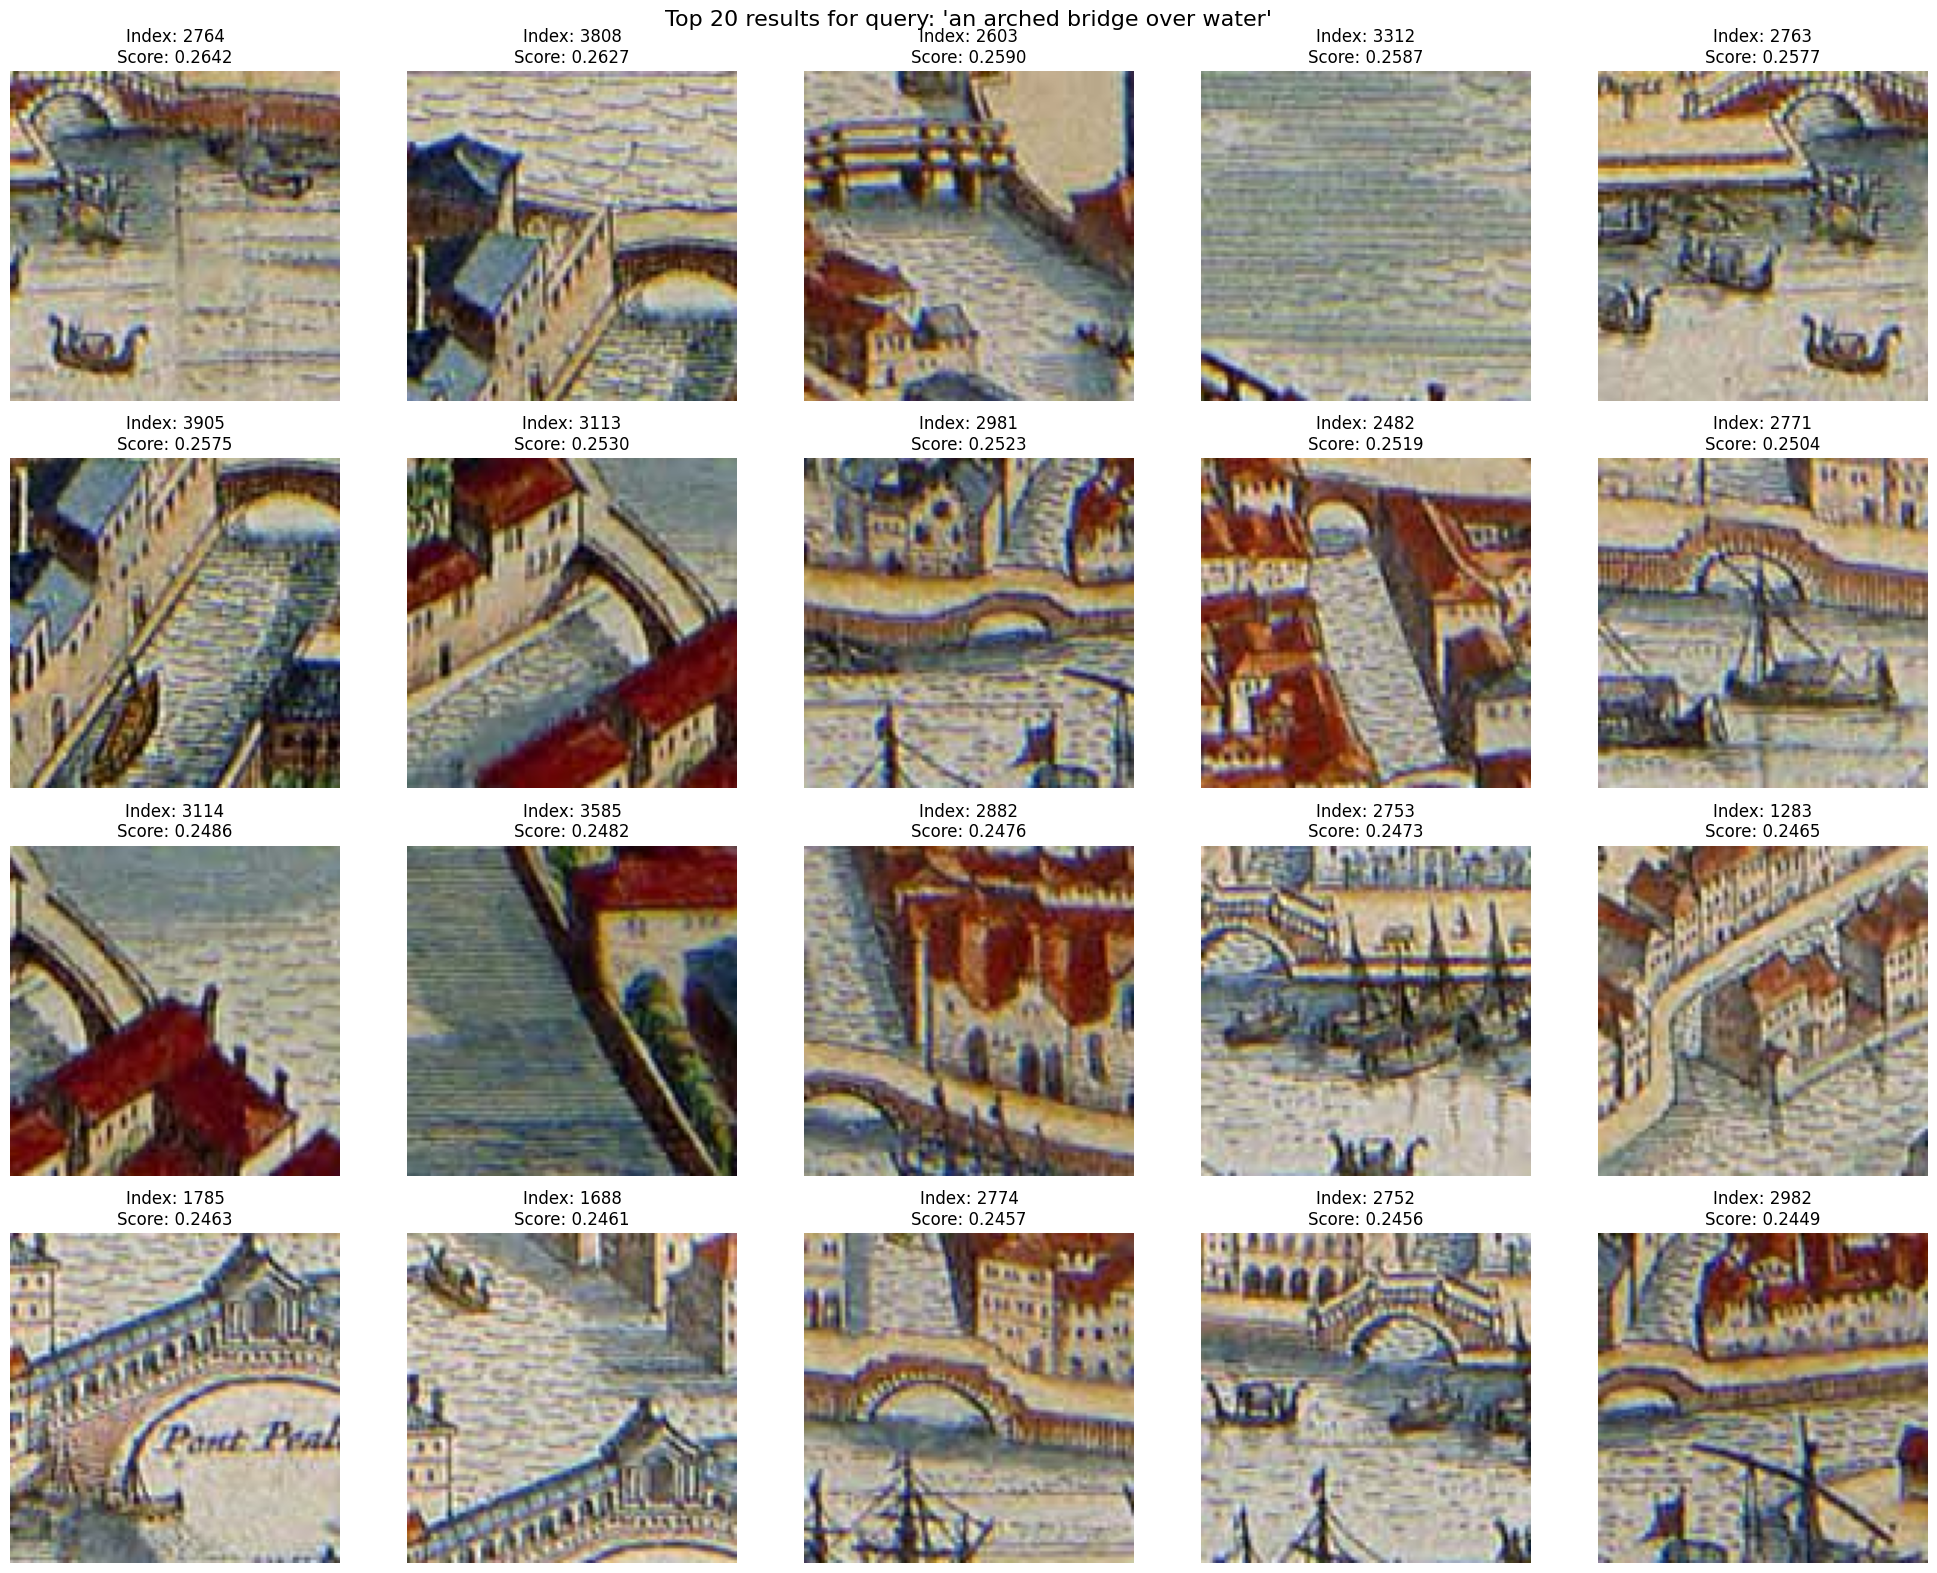

In [16]:
## Search Demo 2 - Text-to-Image
print("\n--- Demo 2: Text-to-Image Search ---")

# Try different query phrases!
# TEXT_QUERY = "a large building with many windows"
# TEXT_QUERY = "an empty field or plaza"
# TEXT_QUERY = "church"
# TEXT_QUERY = "an island in the distance"
# TEXT_QUERY = "house beside trees"
# TEXT_QUERY = "blue building"
# TEXT_QUERY = "a large plaza"
TEXT_QUERY = "an arched bridge over water"

# 1. Extract text features
text_query_vector = extractor.extract_text_features(TEXT_QUERY)

# 2. Perform search
distances, indices = search_engine.search(text_query_vector, k=K_NEIGHBORS)

COLS_PER_ROW = 5
# Automatically calculate the number of rows needed
ROWS = math.ceil(K_NEIGHBORS / COLS_PER_ROW)

# Create a grid (e.g., 3 rows × 5 columns)
fig, axes = plt.subplots(ROWS, COLS_PER_ROW, figsize=(20, 4 * ROWS))
fig.suptitle(f"Top {K_NEIGHBORS} results for query: '{TEXT_QUERY}'", fontsize=16)

axes_flat = axes.flat

for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    result_patch = patches_data[idx]['patch']

    ax = axes_flat[i]  # Get the i-th subplot
    ax.imshow(result_patch)
    ax.set_title(f"Index: {idx}\nScore: {dist:.4f}")
    ax.axis('off')

for i in range(len(indices[0]), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()
